In [1]:
import numpy as np
import math
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('seaborn-deep')
from mpl_toolkits import mplot3d as mpl3d
from scipy import signal, stats, linalg, fft
import tqdm

# import our 'specsens' package with the help of 'sys'
import sys
sys.path.insert(0, '..')
import specsens as ss

In [2]:
# mpl.use("pgf")  # to display graphs remove this line
mpl.rcParams.update({
    'pgf.texsystem': 'pdflatex',
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})
line = 0.75

In [3]:
# general settings for signal and noise
sample_freq = 1e5  # in Hz
length = 15.0  # in s
noise_power = 0.0  # in dB

# create 'DopplerSignal' object
ds = ss.DopplerSignal(
    t_sec=length,  # length of signal in seconds
    f_sample=sample_freq,  # sample frequency after decimation
    f_carrier=450e6,  # frequency of signal before down sapling to baseband
    steps=int(1e3))  # steps / resolution

# get frequency and power vectors that contain the doppler shift
t, freq, signal_power = ds.get(
    f_center=-1e4,  # center frequency at half way point in Hz
    power=5.,  # power at half way point in dB ('peak' power)
    distance=6000.0,  # distance in m
    velocity=8000.0)  # velocity in m/s

# create the signal (the 'very_silent' kind) using the doppler shift vectors
wm = ss.WirelessMicrophone(f_sample=sample_freq, t_sec=length, seed=None)
sig = wm.very_silent(f_center=freq, power=signal_power, dB=True)

# create the noise
wgn = ss.WhiteGaussianNoise(f_sample=sample_freq, t_sec=length)
noise = wgn.signal(power=noise_power, dB=True)

# ensure noise and signal have same length (and create global variable 'num_samples')
assert wm.num_samples == wgn.num_samples
num_samples = wm.num_samples

# create actual signal ('both') comprising of signal and additive white Gaussian noise (AWGN)
both = sig + noise

# print some info about signal and noise
print('Signal power: %.2f dB' % (ss.util.signal_power(sig, dB=True)))
print('Noise power:  %.2f dB' % (ss.util.signal_power(noise, dB=True)))
print('SNR:          %.2f dB' % (ss.util.snr(sig, noise, dB=True)))
print('Num samples:  %d' % (num_samples))

# ensure that Parseval's theorem holds
ss.util.check_parseval(both, length, sample_freq)

Signal power: -0.33 dB
Noise power:  -0.00 dB
SNR:          -0.33 dB
Num samples:  1500000


In [4]:
# use edge detection in spectrum in oder to detect spectrum areas of interest
fft_len = 512

# create a Short Time Fourier Transform object
sft = ss.Stft(n=fft_len, window='flattop')

# use the stft to transform the signal into the frequency domain
f, t, x = sft.spectogram(both, sample_freq, normalized=False, dB=False)

# Variable Band Energy Detector
vbed = ss.VariableBandEnergyDetector(
    fft_len=fft_len,
    freqs=f,
    noise_power=noise_power,
    pfa=0.01,  # !!! has no real meaning here anymore 
    smooth=5.,  # number of ffts used for smoothing
    scale=4,  # number of multi-scale wavelet products
    min_height=0.1,  # min height required
    min_freq=1e3,
    energy_compensation=0.02)  # compensate for leaking energy

# empty overlay picture of edges in spectrum
res = np.empty(shape=(len(f), len(t)))
res[:] = np.nan

# empty detection results
det = np.array([])

# go over spectrum ('in time') and detect
for i, _ in enumerate(tqdm.tqdm(t)):

    # do actual detection
    ps, peak, peakf, dics = vbed.detect(x[:, i])

    # store edges in res
    res = ss.util_wide.store_pic(pic=res,
                                 x=i,
                                 y=peak,
                                 n=3,
                                 val=1.,
                                 minimum=0,
                                 maximum=len(f))

    # store detection results in det
    det = np.append(det, dics)

# # plot spectrum and edges in one picture
# plt.figure(figsize=(8, 6))
# plt.title('Detected edges')
# plt.pcolormesh(t,
#                f,
#                ss.util.dB_power(x),
#                cmap='viridis',
#                vmin=np.min(ss.util.dB_power(x)),
#                vmax=np.max(ss.util.dB_power(x)))
# plt.pcolormesh(t, f, res, cmap='viridis')
# plt.xlabel('Time [s]')
# plt.ylabel('Frequency [Hz]')
# plt.gca().invert_yaxis()
# plt.show()

# # plot detection results
# plt.figure(figsize=(8, 6))
# plt.title('Energy and edge detection combined')
# for i, dic in enumerate(tqdm.tqdm(det)):
#     for j, d in enumerate(dic.items()):
#         plt.plot(t[i], f[int(d[1][1])], 'k_', markersize=2)
#         plt.plot(t[i], f[int(d[0])], 'k_', markersize=2, markeredgewidth=d[1][0] / 1000)
#         plt.plot(t[i], f[int(d[1][2])], 'k_', markersize=2)
# plt.xlabel('Time [s]')
# plt.ylabel('Frequency [Hz]')
# plt.grid(linewidth=0.5)
# plt.gca().set_xlim([np.min(t), np.max(t)])
# plt.gca().set_ylim([np.min(f), np.max(f)])
# plt.gca().invert_yaxis()
# plt.show()

# print some band stats
idx = 1200
print('Entries of %dth fft at time %.3fs: ' % (idx, idx * (t[1] - t[0])))
for j, d in enumerate(det[idx].items()):
    print('--- Entry number %d ---' % (j))
    print('Band center freq: %.2f' % (f[d[0]]))
    print('Energy in band:   %.2f' % (d[1][0]))
    print('Band upper freq:  %.2f' % (f[d[1][1]]))
    print('Band lower freq:  %.2f' % (f[d[1][2]]))
    print('Band width:       %.2f' % (d[1][3] * (f[1] - f[0])))

100%|██████████| 2929/2929 [00:07<00:00, 398.34it/s]

Entries of 1200th fft at time 6.144s: 
--- Entry number 0 ---
Band center freq: -1757.81
Energy in band:   1328.79
Band upper freq:  -2539.06
Band lower freq:  -976.56
Band width:       1562.50


100%|██████████| 2929/2929 [00:04<00:00, 692.69it/s]  


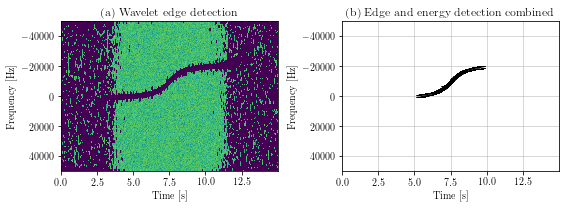

In [5]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(8, 3))

axs[0].pcolormesh(t,
                  f,
                  ss.util.dB_power(x),
                  cmap='viridis',
                  vmin=np.min(ss.util.dB_power(x)),
                  vmax=np.max(ss.util.dB_power(x)))
axs[0].pcolormesh(t, f, res, cmap='viridis')
axs[0].set_xlabel(r'Time [s]')
axs[0].set_ylabel(r'Frequency [Hz]')
axs[0].set_title(r'(a) Wavelet edge detection')
axs[0].set_xlim([np.min(t), np.max(t)])
axs[0].set_ylim([np.min(f), np.max(f)])
axs[0].invert_yaxis()

for i, dic in enumerate(tqdm.tqdm(det)):
    for j, d in enumerate(dic.items()):
        axs[1].plot(t[i], f[int(d[1][1])], 'k_', markersize=2)
        axs[1].plot(t[i],
                    f[int(d[0])],
                    'k_',
                    markersize=2,
                    markeredgewidth=d[1][0] / 10000)
        axs[1].plot(t[i], f[int(d[1][2])], 'k_', markersize=2)
axs[1].set_xlabel(r'Time [s]')
axs[1].set_ylabel(r'Frequency [Hz]')
axs[1].set_title(r'(b) Edge and energy detection combined')
axs[1].grid(linewidth=0.5)
axs[1].set_xlim([np.min(t), np.max(t)])
axs[1].set_ylim([np.min(f), np.max(f)])
axs[1].invert_yaxis()
# axs[0, 1].axvline(0.092,
#                   c='C1',
#                   alpha=0.5,
#                   ls='--',
#                   linewidth=1,
#                   aa=True)

plt.tight_layout()
plt.savefig('out/chap5/wideband_edge_doppler.png', dpi=1200)